<a href="https://colab.research.google.com/github/beruscoder/architectures/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: janstylewis7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:21<00:00, 114MB/s] 


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import os
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from keras.utils import plot_model
from tensorflow.keras.layers import Rescaling


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, auc


In [13]:
data_dir = "/content/chest-xray-pneumonia/chest_xray/train"
val_dir= "/content/chest-xray-pneumonia/chest_xray/val"
test_dir = "/content/chest-xray-pneumonia/chest_xray/test"

#hyperparameters
img_h, img_w = 224,224
epochs = 5
batch = 32

In [14]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size = batch,
    image_size = (img_h,img_w)
)

Found 5216 files belonging to 2 classes.


In [15]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size = batch,
    image_size = (img_h,img_w)
)

Found 16 files belonging to 2 classes.


In [16]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size = batch,
    image_size = (img_h,img_w)
)

Found 624 files belonging to 2 classes.


In [17]:
#augmentation
data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ])

In [18]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training = True),y))

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
def vgg16(input_shape=(224,224,3), num_classes=2):
  model = models.Sequential()

  model.add(Rescaling(1./255, input_shape=input_shape))
    #block 1
  model.add(layers.Conv2D(64,(3,3),padding='same', activation='relu'))
  model.add(layers.Conv2D(64,(3,3),padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    #block2
  model.add(layers.Conv2D(128,(3,3),padding='same', activation='relu'))
  model.add(layers.Conv2D(128,(3,3),padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2,2),strides=(2,2)))

  model.add(layers.Conv2D(256,(3,3),padding='same', activation='relu'))
  model.add(layers.Conv2D(256,(3,3),padding='same', activation='relu'))
  model.add(layers.Conv2D(256,(3,3),padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2,2),strides=(2,2)))

  model.add(layers.Conv2D(512,(3,3),padding='same', activation='relu'))
  model.add(layers.Conv2D(512,(3,3),padding='same', activation='relu'))
  model.add(layers.Conv2D(512,(3,3),padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2,2),strides=(2,2)))

  model.add(layers.Conv2D(512,(3,3),padding='same', activation='relu'))
  model.add(layers.Conv2D(512,(3,3),padding='same', activation='relu'))
  model.add(layers.Conv2D(512,(3,3),padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2,2),strides=(2,2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1,activation='sigmoid'))

  return model

In [20]:
model = vgg16()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,09

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 134,264,641 (512.18 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics =['accuracy'])

In [23]:
final = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 878ms/step - accuracy: 0.7325 - loss: 0.5842 - val_accuracy: 0.5000 - val_loss: 0.9074
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 845ms/step - accuracy: 0.7328 - loss: 0.5848 - val_accuracy: 0.5000 - val_loss: 0.9407
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 825ms/step - accuracy: 0.7329 - loss: 0.5853 - val_accuracy: 0.5000 - val_loss: 0.9334
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 831ms/step - accuracy: 0.7313 - loss: 0.5853 - val_accuracy: 0.5000 - val_loss: 0.8792
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 816ms/step - accuracy: 0.7348 - loss: 0.5838 - val_accuracy: 0.5000 - val_loss: 0.9399


# Reason why val_accuracy is stuck because val data is very less and because of data imabalance only one type of classification is occuring. anyway vgg model is trained for imagenet , and this is random xray dataset for practice

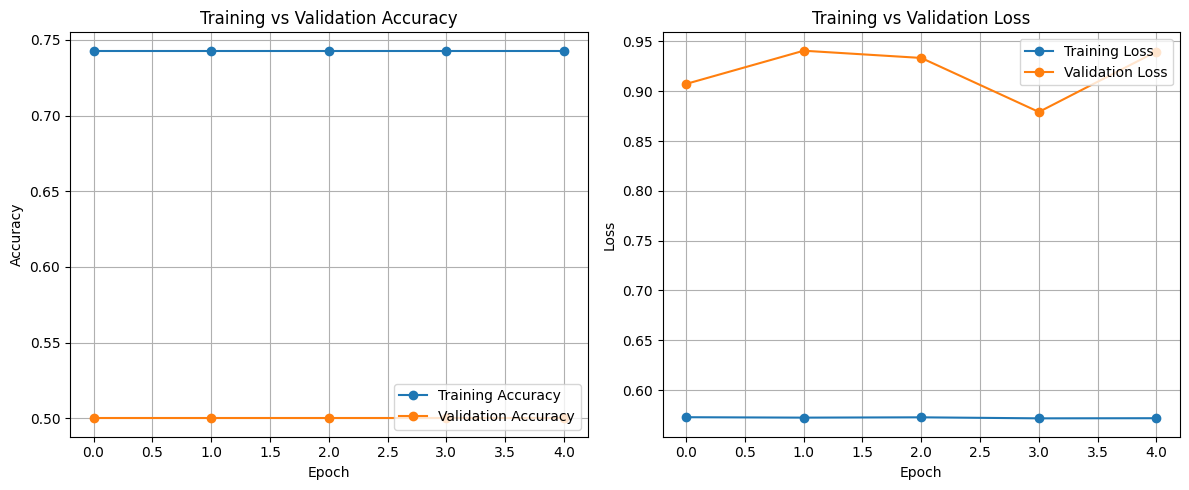

In [26]:
import matplotlib.pyplot as plt

acc = final.history['accuracy']
val_acc = final.history['val_accuracy']
loss = final.history['loss']
val_loss = final.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [27]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.6297 - loss: 0.7501
Test Accuracy: 62.50%
